In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, WeightedRandomSampler
import kagglehub
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import pandas as pd
from tqdm import tqdm
import cv2
from PIL import Image

In [ ]:
path = kagglehub.dataset_download("paultimothymooney/chest-xray-pneumonia")
print(f"Dataset path: {path}")

train_dir = os.path.join(path, 'chest_xray', 'train')
val_dir = os.path.join(path, 'chest_xray', 'val')
test_dir = os.path.join(path, 'chest_xray', 'test')

Dataset path: /kaggle/input/chest-xray-pneumonia


In [ ]:
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomRotation(15),
    transforms.RandomHorizontalFlip(0.5),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

In [ ]:
#검증용
val_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

In [ ]:
train_dataset = torchvision.datasets.ImageFolder(train_dir, transform=train_transform)
val_dataset = torchvision.datasets.ImageFolder(val_dir, transform=val_transform)
test_dataset = torchvision.datasets.ImageFolder(test_dir, transform=val_transform)

In [ ]:
train_normal = len(os.listdir(os.path.join(train_dir, 'NORMAL')))
train_pneumonia = len(os.listdir(os.path.join(train_dir, 'PNEUMONIA')))
print(f"Train: Normal {train_normal}, Pneumonia {train_pneumonia}")
print(f"클래스 불균형 비율: 1:{train_pneumonia/train_normal:.1f}")

Train: Normal 1341, Pneumonia 3875
클래스 불균형 비율: 1:2.9


In [ ]:
#오버샘플림
class_counts = [train_normal, train_pneumonia]
class_weights = [1.0/count for count in class_counts]
sample_weights = [class_weights[label] for _, label in train_dataset]

sampler = WeightedRandomSampler(sample_weights, len(sample_weights))

In [ ]:
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, sampler=sampler)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [ ]:
sample_batch = next(iter(train_loader))
inputs, labels = sample_batch
print(f"Batch shape: {inputs.shape}, Labels: {labels.shape}")

Batch shape: torch.Size([32, 3, 224, 224]), Labels: torch.Size([32])


In [ ]:
classes = train_dataset.classes
print(f"Classes: {classes}")
print(f"Batches - Train: {len(train_loader)}, Val: {len(val_loader)}, Test: {len(test_loader)}")

Classes: ['NORMAL', 'PNEUMONIA']
Batches - Train: 163, Val: 1, Test: 20


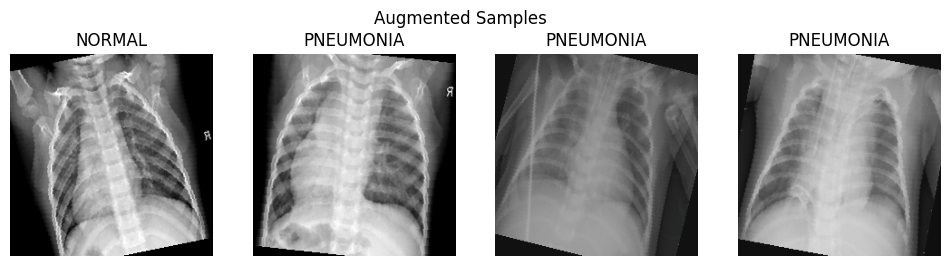

In [ ]:
fig, axes = plt.subplots(1, 4, figsize=(12, 3))
for i in range(4):
    img = inputs[i].permute(1, 2, 0)
    img = img * torch.tensor([0.229, 0.224, 0.225]) + torch.tensor([0.485, 0.456, 0.406])
    img = torch.clamp(img, 0, 1)
    axes[i].imshow(img)
    axes[i].set_title(f'{classes[labels[i]]}')
    axes[i].axis('off')
plt.suptitle('Augmented Samples')
plt.show()

ResNet-50 훈련 (증강버전)

In [ ]:
resnet_model = torchvision.models.resnet50(pretrained=True)
resnet_model.fc = nn.Linear(resnet_model.fc.in_features, 2)


class_weight = torch.tensor([3.0, 1.0])
criterion = nn.CrossEntropyLoss(weight=class_weight)
optimizer = optim.Adam(resnet_model.parameters(), lr=0.001)

num_epochs = 5
best_resnet_acc = 0.0

In [ ]:
for epoch in range(num_epochs):
    resnet_model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for inputs, labels in tqdm(train_loader, desc=f'Epoch {epoch+1}'):
        optimizer.zero_grad()
        outputs = resnet_model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    train_acc = 100. * correct / total

    resnet_model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in val_loader:
            outputs = resnet_model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    val_acc = 100. * correct / total

    if val_acc > best_resnet_acc:
        best_resnet_acc = val_acc

    print(f'Epoch {epoch+1}: Train Acc {train_acc:.2f}%, Val Acc {val_acc:.2f}%')

print(f"ResNet-50 (Augmented) Best Val Acc: {best_resnet_acc:.2f}%")


Epoch 1: 100%|██████████| 163/163 [09:14<00:00,  3.40s/it]


Epoch 1: Train Acc 91.85%, Val Acc 93.75%


Epoch 2: 100%|██████████| 163/163 [09:03<00:00,  3.33s/it]


Epoch 2: Train Acc 94.54%, Val Acc 93.75%


Epoch 3: 100%|██████████| 163/163 [09:03<00:00,  3.33s/it]


Epoch 3: Train Acc 95.15%, Val Acc 93.75%


Epoch 4: 100%|██████████| 163/163 [09:03<00:00,  3.33s/it]


Epoch 4: Train Acc 96.07%, Val Acc 87.50%


Epoch 5: 100%|██████████| 163/163 [09:05<00:00,  3.35s/it]


Epoch 5: Train Acc 95.72%, Val Acc 100.00%
ResNet-50 (Augmented) Best Val Acc: 100.00%


ResNet-50 테스트 (증강버전)

In [ ]:
resnet_predictions = []
resnet_labels = []

with torch.no_grad():
    for inputs, labels in tqdm(test_loader, desc='Testing ResNet (Augmented)'):
        outputs = resnet_model(inputs)
        _, predicted = torch.max(outputs, 1)

        resnet_predictions.extend(predicted.cpu().numpy())
        resnet_labels.extend(labels.cpu().numpy())

# 성능 계산
resnet_accuracy = accuracy_score(resnet_labels, resnet_predictions)
resnet_precision = precision_score(resnet_labels, resnet_predictions, average='weighted')
resnet_recall = recall_score(resnet_labels, resnet_predictions, average='weighted')
resnet_f1 = f1_score(resnet_labels, resnet_predictions, average='weighted')

print(f"ResNet-50 (Augmented) Results:")
print(f"Accuracy: {resnet_accuracy:.4f}")
print(f"Precision: {resnet_precision:.4f}")
print(f"Recall: {resnet_recall:.4f}")
print(f"F1-Score: {resnet_f1:.4f}")

Testing ResNet (Augmented): 100%|██████████| 20/20 [00:27<00:00,  1.39s/it]

ResNet-50 (Augmented) Results:
Accuracy: 0.8926
Precision: 0.8977
Recall: 0.8926
F1-Score: 0.8898


DenseNet-121 훈련 (증강버전)

In [ ]:
densenet_model = torchvision.models.densenet121(pretrained=True)
densenet_model.classifier = nn.Linear(densenet_model.classifier.in_features, 2)

criterion = nn.CrossEntropyLoss(weight=class_weight)
optimizer = optim.Adam(densenet_model.parameters(), lr=0.001)

best_densenet_acc = 0.0

for epoch in range(num_epochs):
    densenet_model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for inputs, labels in tqdm(train_loader, desc=f'Epoch {epoch+1}'):
        optimizer.zero_grad()
        outputs = densenet_model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    train_acc = 100. * correct / total

    densenet_model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in val_loader:
            outputs = densenet_model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    val_acc = 100. * correct / total

    if val_acc > best_densenet_acc:
        best_densenet_acc = val_acc

    print(f'Epoch {epoch+1}: Train Acc {train_acc:.2f}%, Val Acc {val_acc:.2f}%')

print(f"DenseNet-121 (Augmented) Best Val Acc: {best_densenet_acc:.2f}%")


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DenseNet121_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet121_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/densenet121-a639ec97.pth" to /root/.cache/torch/hub/checkpoints/densenet121-a639ec97.pth
100%|██████████| 30.8M/30.8M [00:00<00:00, 225MB/s]
Epoch 1: 100%|██████████| 163/163 [09:29<00:00,  3.49s/it]


Epoch 1: Train Acc 92.68%, Val Acc 68.75%


Epoch 2: 100%|██████████| 163/163 [09:23<00:00,  3.45s/it]


Epoch 2: Train Acc 94.75%, Val Acc 62.50%


Epoch 3: 100%|██████████| 163/163 [09:28<00:00,  3.49s/it]


Epoch 3: Train Acc 95.95%, Val Acc 93.75%


Epoch 4: 100%|██████████| 163/163 [09:28<00:00,  3.49s/it]


Epoch 4: Train Acc 96.13%, Val Acc 68.75%


Epoch 5: 100%|██████████| 163/163 [09:25<00:00,  3.47s/it]


Epoch 5: Train Acc 96.82%, Val Acc 81.25%
DenseNet-121 (Augmented) Best Val Acc: 93.75%


 DenseNet-121 테스트 (증강버전)

In [ ]:
densenet_predictions = []
densenet_labels = []

with torch.no_grad():
    for inputs, labels in tqdm(test_loader, desc='Testing DenseNet (Augmented)'):
        outputs = densenet_model(inputs)
        _, predicted = torch.max(outputs, 1)

        densenet_predictions.extend(predicted.cpu().numpy())
        densenet_labels.extend(labels.cpu().numpy())

# 성능 계산
densenet_accuracy = accuracy_score(densenet_labels, densenet_predictions)
densenet_precision = precision_score(densenet_labels, densenet_predictions, average='weighted')
densenet_recall = recall_score(densenet_labels, densenet_predictions, average='weighted')
densenet_f1 = f1_score(densenet_labels, densenet_predictions, average='weighted')

print(f"DenseNet-121 (Augmented) Results:")
print(f"Accuracy: {densenet_accuracy:.4f}")
print(f"Precision: {densenet_precision:.4f}")
print(f"Recall: {densenet_recall:.4f}")
print(f"F1-Score: {densenet_f1:.4f}")

Testing DenseNet (Augmented): 100%|██████████| 20/20 [00:24<00:00,  1.23s/it]

DenseNet-121 (Augmented) Results:
Accuracy: 0.8574
Precision: 0.8789
Recall: 0.8574
F1-Score: 0.8489


In [ ]:
comparison_df = pd.DataFrame({
    'Model': ['ResNet-50 (Aug)', 'DenseNet-121 (Aug)'],
    'Accuracy': [resnet_accuracy, densenet_accuracy],
    'Precision': [resnet_precision, densenet_precision],
    'Recall': [resnet_recall, densenet_recall],
    'F1-Score': [resnet_f1, densenet_f1]
})

print("Augmented Model Comparison:")
print(comparison_df.round(4))

Augmented Model Comparison:
                Model  Accuracy  Precision  Recall  F1-Score
0     ResNet-50 (Aug)    0.8926     0.8977  0.8926    0.8898
1  DenseNet-121 (Aug)    0.8574     0.8789  0.8574    0.8489


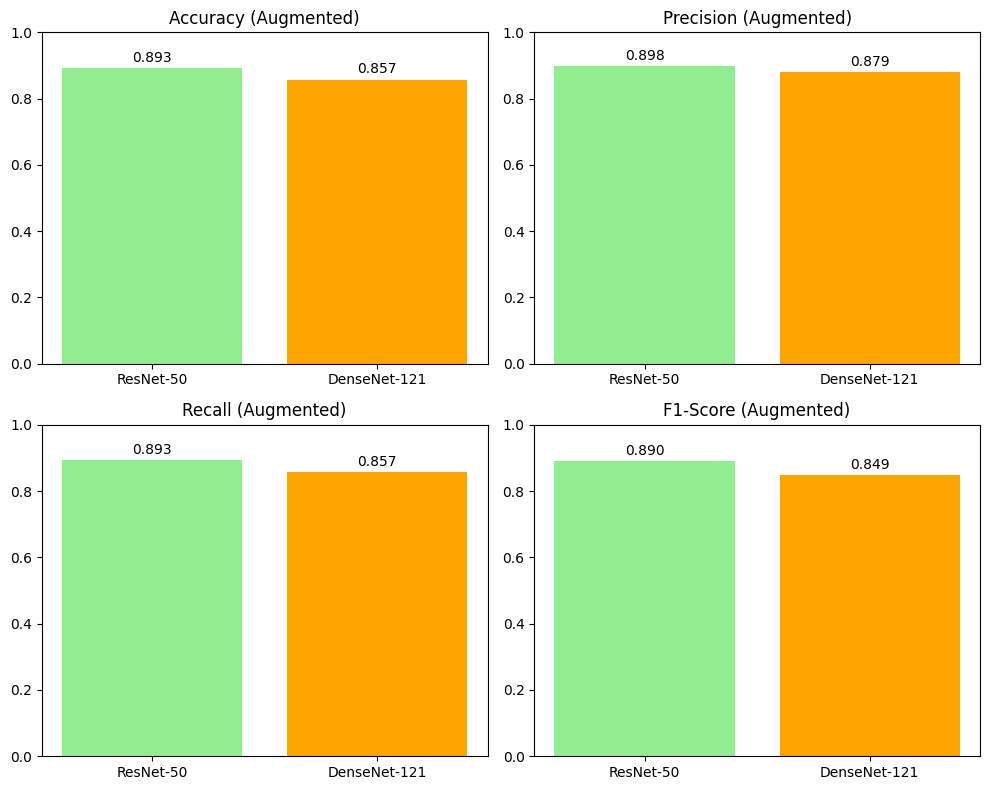

In [ ]:
fig, axes = plt.subplots(2, 2, figsize=(10, 8))

metrics = ['Accuracy', 'Precision', 'Recall', 'F1-Score']
resnet_scores = [resnet_accuracy, resnet_precision, resnet_recall, resnet_f1]
densenet_scores = [densenet_accuracy, densenet_precision, densenet_recall, densenet_f1]

for i, metric in enumerate(metrics):
    ax = axes[i//2, i%2]
    bars = ax.bar(['ResNet-50', 'DenseNet-121'],
                  [resnet_scores[i], densenet_scores[i]],
                  color=['lightgreen', 'orange'])
    ax.set_title(f'{metric} (Augmented)')
    ax.set_ylim([0, 1])

    # 값 표시
    for j, bar in enumerate(bars):
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height + 0.01,
                f'{[resnet_scores[i], densenet_scores[i]][j]:.3f}',
                ha='center', va='bottom')

plt.tight_layout()
plt.show()

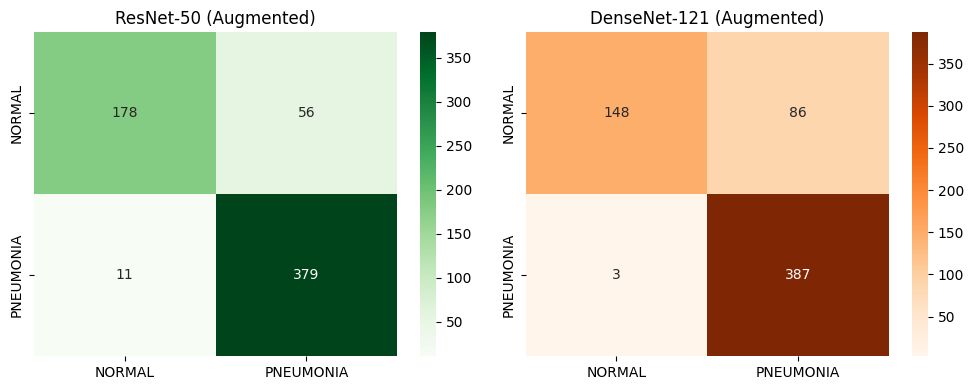

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))

cm_resnet = confusion_matrix(resnet_labels, resnet_predictions)
sns.heatmap(cm_resnet, annot=True, fmt='d', cmap='Greens',
            xticklabels=classes, yticklabels=classes, ax=ax1)
ax1.set_title('ResNet-50 (Augmented)')

cm_densenet = confusion_matrix(densenet_labels, densenet_predictions)
sns.heatmap(cm_densenet, annot=True, fmt='d', cmap='Oranges',
            xticklabels=classes, yticklabels=classes, ax=ax2)
ax2.set_title('DenseNet-121 (Augmented)')

plt.tight_layout()
plt.show()


In [ ]:
def get_gradcam(model, target_layer, input_tensor, target_class=None):
    model.eval()

    # Hook 등록
    gradients = []
    activations = []

    def backward_hook(module, grad_input, grad_output):
        gradients.append(grad_output[0])

    def forward_hook(module, input, output):
        activations.append(output)

    handle_b = target_layer.register_backward_hook(backward_hook)
    handle_f = target_layer.register_forward_hook(forward_hook)

    output = model(input_tensor)
    if target_class is None:
        target_class = torch.argmax(output, dim=1).item()

    model.zero_grad()
    class_score = output[0, target_class]
    class_score.backward()

    gradient = gradients[0][0]
    activation = activations[0][0]


    weights = torch.mean(gradient, dim=[1, 2])


    cam = torch.zeros(activation.shape[1:])
    for i in range(len(weights)):
        cam += weights[i] * activation[i, :, :]


    cam = torch.clamp(cam, min=0)
    if torch.max(cam) > 0:
        cam = cam / torch.max(cam)


    handle_b.remove()
    handle_f.remove()

    return cam.detach().numpy()

sample_normal = os.path.join(test_dir, 'NORMAL', os.listdir(os.path.join(test_dir, 'NORMAL'))[0])
sample_pneumonia = os.path.join(test_dir, 'PNEUMONIA', os.listdir(os.path.join(test_dir, 'PNEUMONIA'))[0])

samples = [(sample_normal, 'NORMAL'), (sample_pneumonia, 'PNEUMONIA')]


ResNet-50 (Augmented) GradCAM:


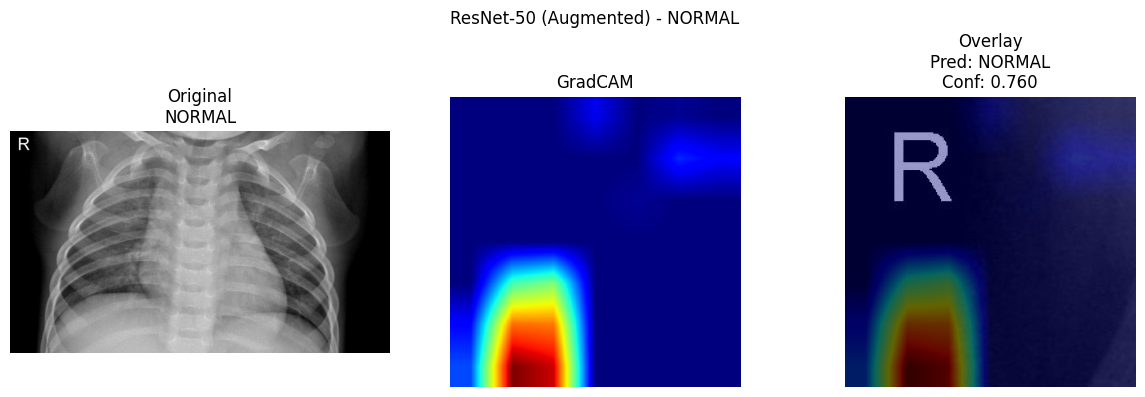

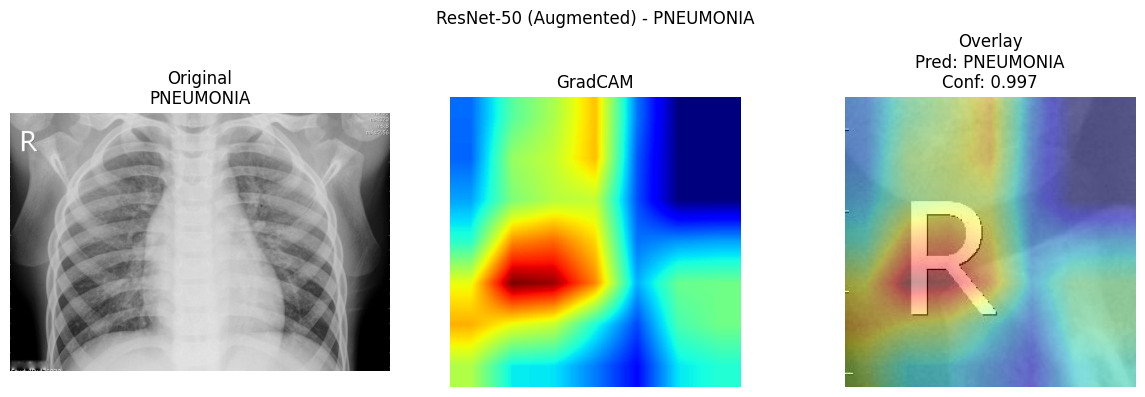

In [ ]:
print("ResNet-50 (Augmented) GradCAM:")
for img_path, true_class in samples:
    image = Image.open(img_path).convert('RGB')
    input_tensor = val_transform(image).unsqueeze(0)

    with torch.no_grad():
        output = resnet_model(input_tensor)
        predicted_class = torch.argmax(output, dim=1).item()
        confidence = torch.softmax(output, dim=1)[0, predicted_class].item()

    cam = get_gradcam(resnet_model, resnet_model.layer4[-1].conv3, input_tensor)
    cam_resized = cv2.resize(cam, (224, 224))

    fig, axes = plt.subplots(1, 3, figsize=(12, 4))

    axes[0].imshow(image)
    axes[0].set_title(f'Original\n{true_class}')
    axes[0].axis('off')

    axes[1].imshow(cam_resized, cmap='jet')
    axes[1].set_title('GradCAM')
    axes[1].axis('off')

    axes[2].imshow(image)
    axes[2].imshow(cam_resized, cmap='jet', alpha=0.4)
    axes[2].set_title(f'Overlay\nPred: {classes[predicted_class]}\nConf: {confidence:.3f}')
    axes[2].axis('off')

    plt.suptitle(f'ResNet-50 (Augmented) - {true_class}')
    plt.tight_layout()
    plt.show()


DenseNet-121 (Augmented) GradCAM:


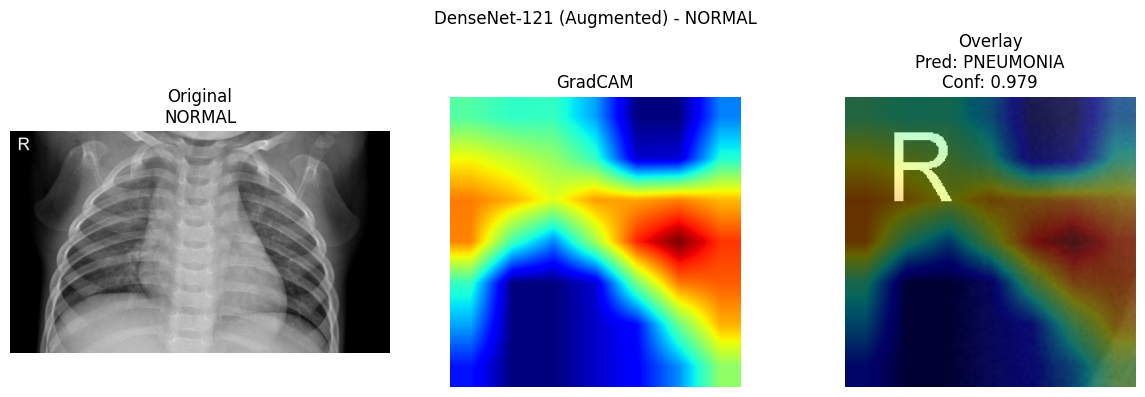

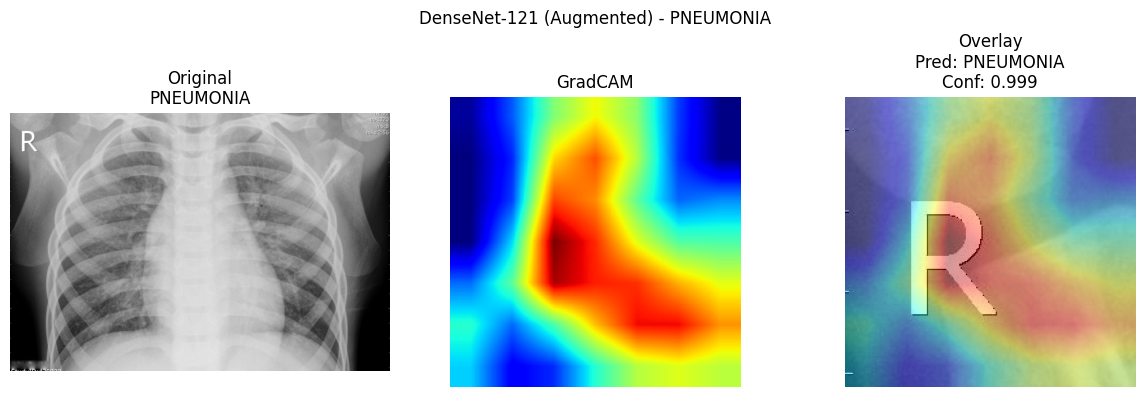

In [ ]:
print("DenseNet-121 (Augmented) GradCAM:")
for img_path, true_class in samples:
    image = Image.open(img_path).convert('RGB')
    input_tensor = val_transform(image).unsqueeze(0)

    with torch.no_grad():
        output = densenet_model(input_tensor)
        predicted_class = torch.argmax(output, dim=1).item()
        confidence = torch.softmax(output, dim=1)[0, predicted_class].item()

    cam = get_gradcam(densenet_model, densenet_model.features.norm5, input_tensor)
    cam_resized = cv2.resize(cam, (224, 224))

    fig, axes = plt.subplots(1, 3, figsize=(12, 4))

    axes[0].imshow(image)
    axes[0].set_title(f'Original\n{true_class}')
    axes[0].axis('off')

    axes[1].imshow(cam_resized, cmap='jet')
    axes[1].set_title('GradCAM')
    axes[1].axis('off')

    axes[2].imshow(image)
    axes[2].imshow(cam_resized, cmap='jet', alpha=0.4)
    axes[2].set_title(f'Overlay\nPred: {classes[predicted_class]}\nConf: {confidence:.3f}')
    axes[2].axis('off')

    plt.suptitle(f'DenseNet-121 (Augmented) - {true_class}')
    plt.tight_layout()
    plt.show()

성능 비교:
ResNet-50:
  Baseline:  0.8462
  Augmented: 0.8926
  Change:    +0.0464
DenseNet-121:
  Baseline:  0.8125
  Augmented: 0.8574
  Change:    +0.0449


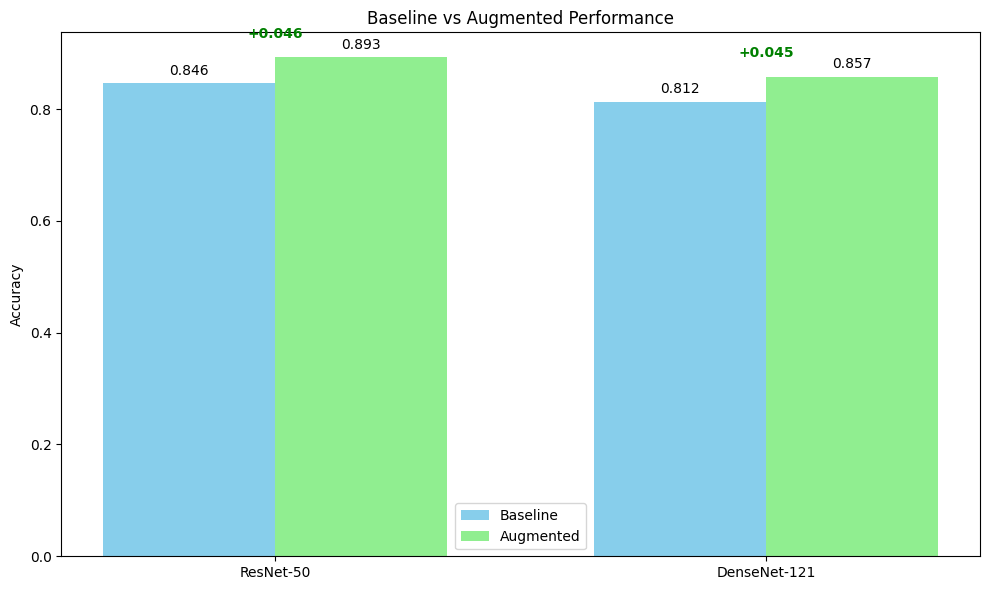

In [ ]:
baseline_resnet = 0.8462
baseline_densenet = 0.8125

print(f"성능 비교:")
print(f"ResNet-50:")
print(f"  Baseline:  {baseline_resnet:.4f}")
print(f"  Augmented: {resnet_accuracy:.4f}")
print(f"  Change:    {resnet_accuracy - baseline_resnet:+.4f}")

print(f"DenseNet-121:")
print(f"  Baseline:  {baseline_densenet:.4f}")
print(f"  Augmented: {densenet_accuracy:.4f}")
print(f"  Change:    {densenet_accuracy - baseline_densenet:+.4f}")

# 비교 시각화
fig, ax = plt.subplots(1, 1, figsize=(10, 6))

models = ['ResNet-50', 'DenseNet-121']
baseline_acc = [baseline_resnet, baseline_densenet]
augmented_acc = [resnet_accuracy, densenet_accuracy]

x = np.arange(len(models))
width = 0.35

bars1 = ax.bar(x - width/2, baseline_acc, width, label='Baseline', color='skyblue')
bars2 = ax.bar(x + width/2, augmented_acc, width, label='Augmented', color='lightgreen')

ax.set_ylabel('Accuracy')
ax.set_title('Baseline vs Augmented Performance')
ax.set_xticks(x)
ax.set_xticklabels(models)
ax.legend()

# 값 표시
for i, (bar1, bar2) in enumerate(zip(bars1, bars2)):
    height1 = bar1.get_height()
    height2 = bar2.get_height()
    ax.text(bar1.get_x() + bar1.get_width()/2., height1 + 0.01,
            f'{height1:.3f}', ha='center', va='bottom')
    ax.text(bar2.get_x() + bar2.get_width()/2., height2 + 0.01,
            f'{height2:.3f}', ha='center', va='bottom')

    # 개선량 표시
    improvement = height2 - height1
    ax.annotate(f'{improvement:+.3f}',
                xy=(i, max(height1, height2) + 0.03),
                ha='center', va='bottom', fontweight='bold',
                color='red' if improvement < 0 else 'green')

plt.tight_layout()
plt.show()

증강 전 후 F1 - Score가 83 vs 79 증강후도 88.9 vs 84로 ResNet이 우세하다 증강은 15도 좌우반전 colorjitter 그리고 오버샘플링 을 진행했고 정확도가 ResNet 4.64% / DenseNet 4.49% 로 둘 다 증강후 4.5%정도 성능이 향상됐다.

결과적으로 ResNet이 우수했고 CAM을 확인했을때도 DenseNet은 퍼지는 형상을 보이지만 ResNet은 비교적 명확하게 보여주고 있다. DenseNet 169이면 어떤 결과가 나올지 궁금하기도 하다.
데이터 분할을 다시하고 epoch과 배치 사이즈를 조절해서 다시 해보면 더 괜찮은 Learning Curve를 얻어볼 수 있을 것 같다.
컴퓨팅 단위가 얼마 안남아서 이쯤에서 마무리 지어보겠습니다.